In [ ]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)


In [ ]:
class LIF:

    def __init__(self, tau = 10, threshold = 5, u_rest = 0, R=1, dt = 0.01):
    
        self.u_rest = u_rest
        self.threshold = threshold
        self.tau = tau
        self.R = R
        self.u = u_rest
        self.dt = dt
        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.cnt = 0 
        self.simulation_history = list()

    def log_tick_info(self, current_I, time):
        self.u_history.append(self.u)
        self.I_history.append(current_I)

    def next_tick(self, current_I, time):
        
        self.u += (-(self.u - self.u_rest) + self.R*current_I)*self.dt/self.tau
        self.check_spike(time)
        self.log_tick_info(current_I, time)
        
        
    def check_spike(self, time):

        if self.u >= self.threshold:
            self.u = self.u_rest
            self.spike_history.append(time)
        

    def get_threshold(self):
        return self.threshold
    def get_spike_frequency(self, I_function, duration = 30):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            if len(self.spike_history)> 0:
                break
        if len(self.spike_history)  == 0:
            return -1
        return 1/self.spike_history[0]
    
    def simulate(self, I_function, duration = 30, complete_simulation= True):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            if not complete_simulation and len(self.spike_history)> 0:
                break

        if complete_simulation:
            self.log()
        
    def log(self):
        self.simulation_history.append((self.u_history, self.spike_history, self.I_history))

In [ ]:
class ELIF:

    def __init__(self, tau = 10, firing_threshold = 1,reset_threshold = 10, sharpness= 1,u_rest = 0, R=1):
    
        self.sharpness = sharpness
        self.firing_threshold = firing_threshold
        self.reset_threshold = reset_threshold
        self.u_rest = u_rest
        self.tau = tau
        self.R = R
        self.u = u_rest
        self.dt = 0.01
        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.cnt = 0 
        self.simulation_history = list()
        self.in_spike = False 

    def log_tick_info(self, current_I, time):
        self.u_history.append(self.u)
        self.I_history.append(current_I)

    def next_tick(self, current_I, time):
        
        self.u += (-(self.u - self.u_rest) + self.sharpness*math.exp((self.u-self.firing_threshold)/self.sharpness) +
                   self.R*current_I )*self.dt/self.tau
        self.check_spike(time)
        self.log_tick_info(current_I, time)
        
        
    def check_spike(self, time):
        
        if not self.in_spike and self.u > self.firing_threshold:
            self.spike_history.append(time)            
            self.in_spike = True
        if self.u >= self.reset_threshold:
            self.u = self.u_rest
            self.in_spike = False

    def get_threshold(self):
        return self.firing_threshold
    
    def get_spike_frequency(self, I_function, duration = 30):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest
        self.in_spike = False

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            if len(self.spike_history)> 0:
                break
        if len(self.spike_history)  == 0:
            return -1
        return 1/(self.spike_history[0])
    
    def simulate(self, I_function, duration = 30, complete_simulation= True):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest
        self.in_spike = False

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            if not complete_simulation and len(self.spike_history)> 0:
                break

        if complete_simulation:
            self.log()
        
    def log(self):
        self.simulation_history.append((self.u_history, self.spike_history, self.I_history))

In [ ]:
class A_ELIF:

    def __init__(self, tau = 5, firing_threshold = 1,reset_threshold = 10, sharpness= 1,u_rest = 0, R=1, a= 0, b=10, tau_w=2, u_reset = 0):
        
        self.a = a
        self.b = b
        self.tau_w = tau_w
        self.w = 0
        self.u_reset = u_rest - 0.5
        self.sharpness = sharpness
        self.firing_threshold = firing_threshold
        self.reset_threshold = reset_threshold
        self.u_rest = u_rest
        self.tau = tau
        self.R = R
        self.u = u_rest
        self.dt = 0.01
        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.cnt = 0 
        self.simulation_history = list()
        self.in_spike = False 
        self.last_spike = -1

    def log_tick_info(self, current_I, time):
        self.u_history.append(self.u)
        self.I_history.append(current_I)

        
    def next_tick(self, current_I, time):
        self.u += (-(self.u - self.u_rest) + self.sharpness*math.exp((self.u-self.firing_threshold)/self.sharpness) +
                   self.R*current_I - self.R*self.w)*self.dt/self.tau
        self.check_spike(time)
        self.w += (self.a*(self.u - self.u_rest) - self.w )*self.dt/self.tau_w+ self.b*self.spike_function(time)
        self.log_tick_info(current_I, time)
        
    def spike_function(self, time):
        return (self.last_spike == time) *1

    def get_threshold(self):
        return self.firing_threshold
    
    def check_spike(self, time):
        
        if not self.in_spike and self.u > self.firing_threshold:
            self.spike_history.append(time)            
            self.in_spike = True
        if self.u >= self.reset_threshold:
            self.last_spike = time
            self.u = self.u_reset
            self.in_spike = False

    def get_spike_frequency(self, I_function, duration = 30):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest
        self.w = 0
        self.in_spike = False

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            
        return len(self.spike_history)/duration
        
    def simulate(self, I_function, duration = 30, complete_simulation= True):

        self.u_history = list()
        self.spike_history = list()
        self.I_history = list()
        self.u = self.u_rest
        self.w = 0
        self.in_spike = False

        for i in np.arange(0,duration,self.dt):
            self.next_tick(I_function(i), i)
            if not complete_simulation and len(self.spike_history)> 0:
                break

        if complete_simulation:
            self.log()
        
    def log(self):
        self.simulation_history.append((self.u_history, self.spike_history, self.I_history))

In [ ]:
def constant_low_I(i):
    return 10*(i>1)

def constant_med_I(i):
    return 20*(i>7)

def constant_high_I(i):
    return 50*(i>12)


In [ ]:
def make_results_with_constant_I(neuron, duration, FI_duration= 500, FI_range = (8 , 20, 0.2), ex= 0 ):
    neuron.simulate(constant_low_I,duration)
    neuron.simulate(constant_med_I,duration)
    neuron.simulate(constant_high_I,duration)
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(3, 1)
    ax_F_I = fig.add_subplot(gs[2,0])
    ax_u = fig.add_subplot(gs[0,0])
    ax_I = fig.add_subplot(gs[1,0])
    ax_u.set_title("Experiment {}".format(ex))
    ticks = int(duration / neuron.dt)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[2][0], ax= ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[2][2], ax= ax_I)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[1][0], ax = ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[1][2], ax = ax_I)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[0][0], ax = ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[0][2], ax = ax_I)
    ax_u.axhline(y=neuron.get_threshold(), color='black', linestyle='--')
    ax_u.axhline(y=neuron.u_rest, color='black', linestyle='--')
    
    ax_u.set(ylim=(-70, -45))
    ax_u.set(ylabel="u", xlabel = "time(S)")
    ax_I.set(ylim=(0, 80))
    ax_I.set(ylabel="I", xlabel = "time(S)")
    ax_F_I.set(ylim=(0, 0.1))
    ax_F_I.set(xlim=(FI_range[0], FI_range[1]))
    ax_F_I.set(xlabel="I", ylabel = "F")
    print("hi")
    Fs,Is = list(),list()
    for i in np.arange(*FI_range):
        f = neuron.get_spike_frequency(lambda x:i, FI_duration)
        if f != -1:
            Fs.append(f)
            Is.append(i)
    sns.lineplot(Is,Fs, ax = ax_F_I)
    plt.show()
    

In [ ]:
import random
random_array = [25]
for i in range(6000):
    random_array.append(max(random_array[-1] +random.randint(-5, 5), 0))
def random_I(time):
    return random_array[int(time)]

## Project 1

### Exp 1

hi


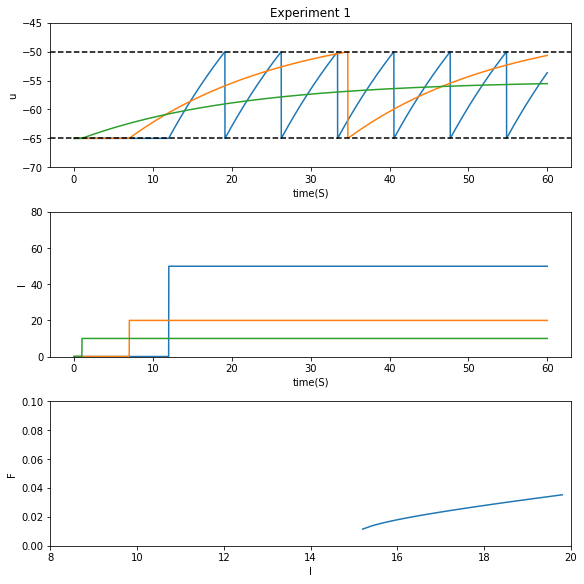

In [ ]:
lif_neuron1 = LIF(tau = 20, threshold =-50 , u_rest= -65,  R = 1)
make_results_with_constant_I(lif_neuron1, 60, ex = 1)

### Exp 2

hi


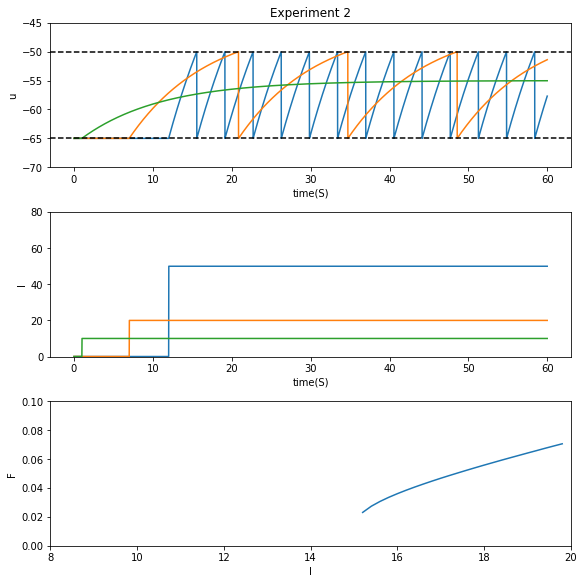

In [ ]:
lif_neuron2 = LIF(tau = 10, threshold =-50 , u_rest= -65,  R = 1)
make_results_with_constant_I(lif_neuron2, 60, ex = 2)

### Exp 3

hi


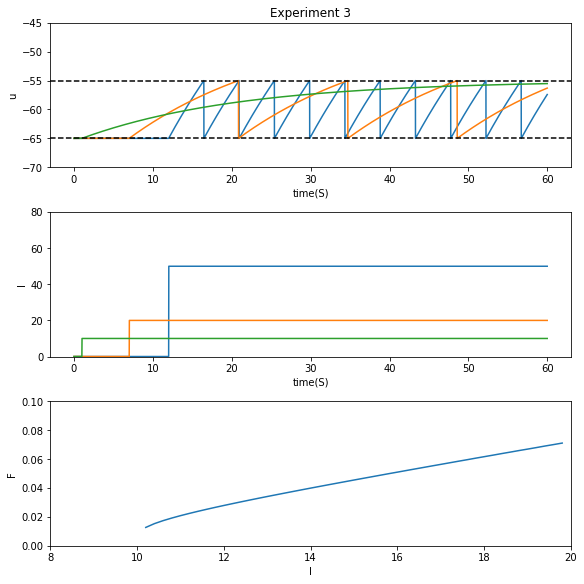

In [ ]:
lif_neuron3 = LIF(tau = 20, threshold =-55 , u_rest= -65,  R = 1)
make_results_with_constant_I(lif_neuron3, 60, ex = 3)

### Exp 4

hi


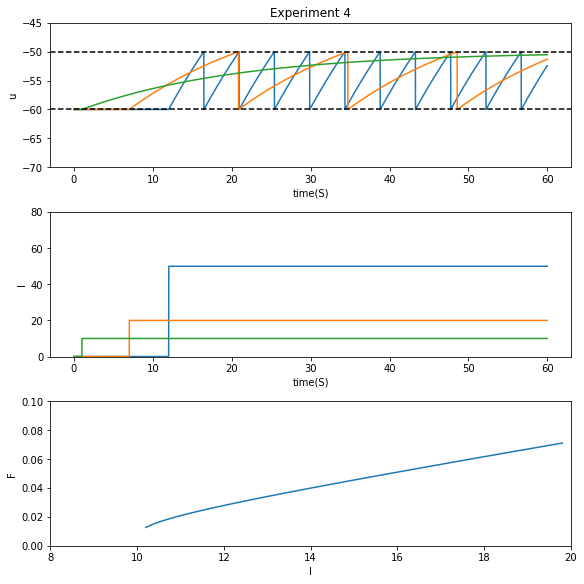

In [ ]:
lif_neuron4 = LIF(tau = 20, threshold =-50 , u_rest= -60,  R = 1)
make_results_with_constant_I(lif_neuron4, 60, ex = 4)

### Exp 5

hi


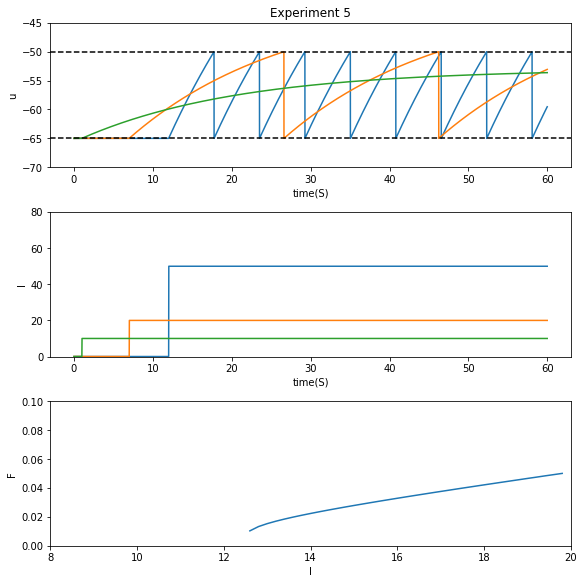

In [ ]:
lif_neuron5 = LIF(tau = 20, threshold =-50 , u_rest= -65,  R = 1.2)
make_results_with_constant_I(lif_neuron5, 60, ex = 5)

## Project 2

In [ ]:
def make_results_with_random_I(neuron, duration):
    neuron.simulate(random_I,duration)
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 1)
    ax_u = fig.add_subplot(gs[0,0])
    ax_I = fig.add_subplot(gs[1,0])
    ticks = int(duration / neuron.dt)
    sns.lineplot(np.arange(ticks)/100,neuron.simulation_history[0][0], ax = ax_u)
    sns.lineplot(np.arange(ticks)/100,neuron.simulation_history[0][2], ax = ax_I)
    ax_u.axhline(y=neuron.get_threshold(), color='black', linestyle='--')
    ax_u.axhline(y=neuron.u_rest, color='black', linestyle='--')
    ax_u.set(ylim=(-85, -20))
    ax_u.set(ylabel="u", xlabel = "time(S)")
    ax_I.set(ylim=(0, 80))
    ax_I.set(ylabel="I", xlabel = "time(S)")

### Exp 1

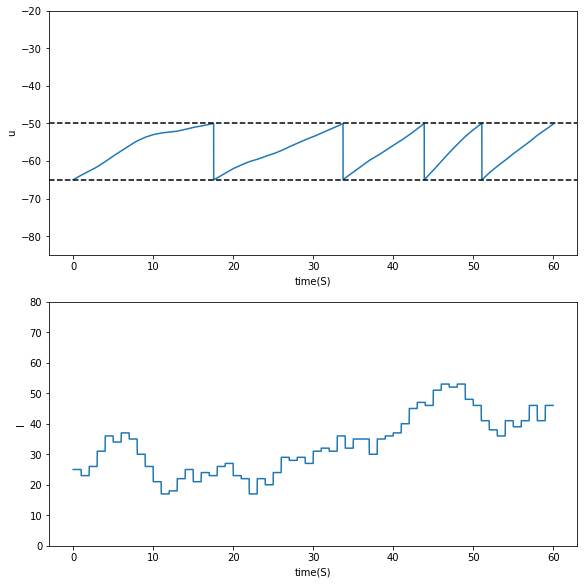

In [ ]:
lif2_neuron1 = LIF(tau = 20, threshold =-50 , u_rest= -65,  R = 1)
make_results_with_random_I(lif2_neuron1, 60)

### Exp 2

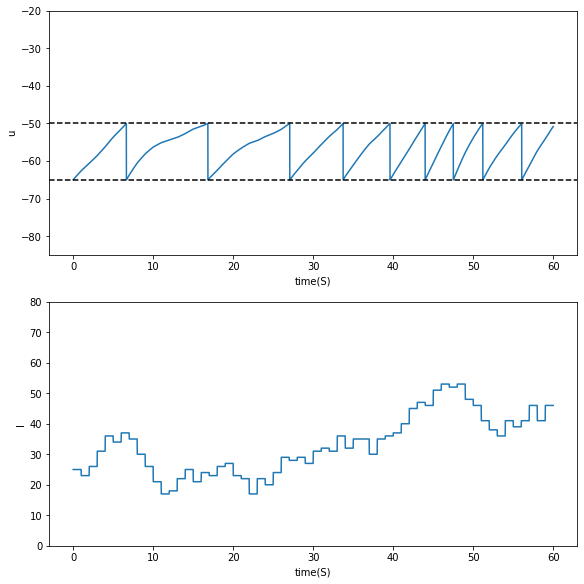

In [ ]:
lif2_neuron2 = LIF(tau = 10, threshold =-50 , u_rest= -65,  R = 1)
make_results_with_random_I(lif2_neuron2, 60)

### Exp 3

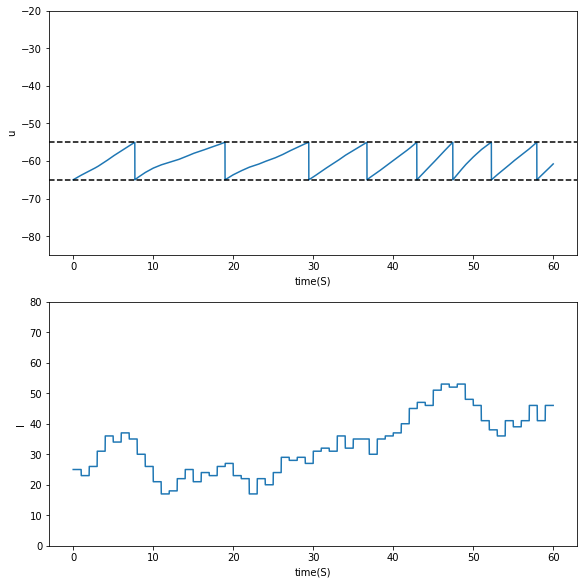

In [ ]:
lif2_neuron3 = LIF(tau = 20, threshold =-55 , u_rest= -65,  R = 1)
make_results_with_random_I(lif2_neuron3, 60)

### Exp 4

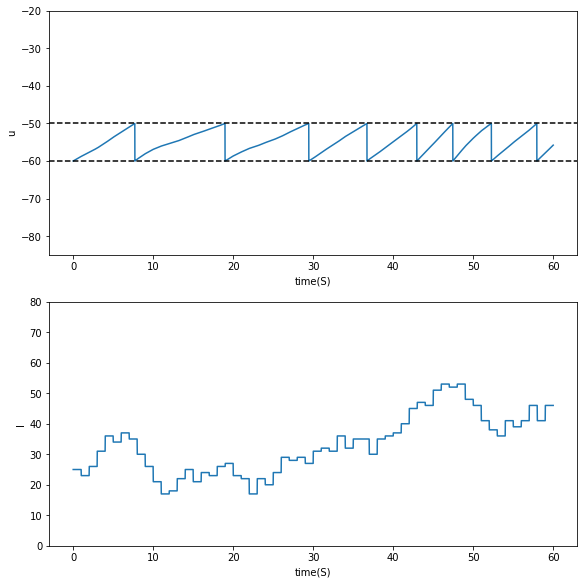

In [ ]:
lif2_neuron4 = LIF(tau = 20, threshold =-50 , u_rest= -60,  R = 1)
make_results_with_random_I(lif2_neuron4, 60)

### Exp 5

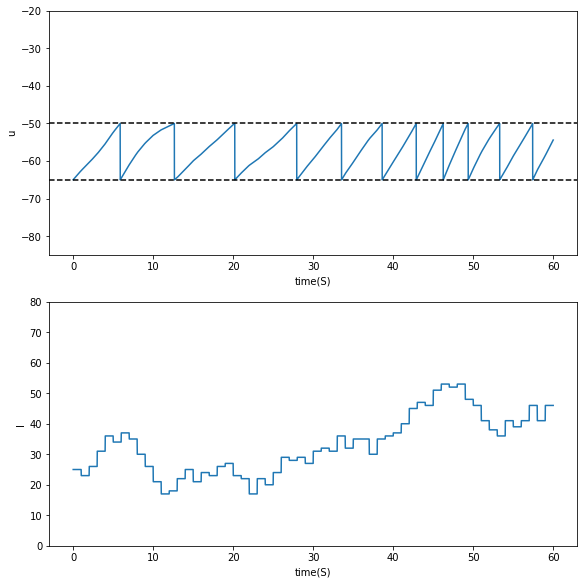

In [ ]:
lif2_neuron5 = LIF(tau = 20, threshold =-50 , u_rest= -65,  R = 2)
make_results_with_random_I(lif2_neuron5, 60)

## Project 3

In [ ]:
def make_results(neuron, duration, FI_duration= 500, FI_range = (8 , 20, 0.2), ex= 0 ):
    neuron.simulate(constant_low_I,duration)
    neuron.simulate(constant_med_I,duration)
    neuron.simulate(constant_high_I,duration)
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(6, 2)
    ax_u_r = fig.add_subplot(gs[1:3,1])
    ax_I_r = fig.add_subplot(gs[3:5,1])
    ax_F_I = fig.add_subplot(gs[4:,0])
    ax_u = fig.add_subplot(gs[:2,0])
    ax_I = fig.add_subplot(gs[2:4,0])
    ticks = int(duration / neuron.dt)
    ax_u.set(ylim=(-85 -20))
    ax_u.set(ylabel="u", xlabel = "time(S)")
    ax_I.set(ylim=(0, 80))
    ax_I.set(ylabel="I", xlabel = "time(S)")
    ax_F_I.set(ylim=(0, 0.1))
    ax_F_I.set(xlim=(FI_range[0], FI_range[1]))
    ax_F_I.set(xlabel="I", ylabel = "F")
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[2][0], ax= ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[2][2], ax= ax_I)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[1][0], ax = ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[1][2], ax = ax_I)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[0][0], ax = ax_u)
    sns.lineplot(np.arange(ticks)*neuron.dt,neuron.simulation_history[0][2], ax = ax_I)
    ax_u.axhline(y=neuron.get_threshold(), color='black', linestyle='--')
    ax_u.axhline(y=neuron.u_rest, color='black', linestyle='--')
    

    print("hi")
    Fs,Is = list(),list()
    for i in np.arange(*FI_range):
        f = neuron.get_spike_frequency(lambda x:i, FI_duration)
        if f != -1:
            Fs.append(f)
            Is.append(i)
            
    neuron.simulate(random_I,duration)
    sns.lineplot(Is,Fs, ax = ax_F_I)
    ticks = int(duration / neuron.dt)
    sns.lineplot(np.arange(ticks)/100,neuron.simulation_history[-1][0], ax = ax_u_r)
    sns.lineplot(np.arange(ticks)/100,neuron.simulation_history[-1][2], ax = ax_I_r)
    ax_u_r.axhline(y=neuron.get_threshold(), color='black', linestyle='--')
    ax_u_r.axhline(y=neuron.u_rest, color='black', linestyle='--')
    ax_u_r.set(ylim=(-85, -20))
    ax_u_r.set(ylabel="u", xlabel = "time(S)")
    ax_I_r.set(ylim=(0, 80))
    ax_I_r.set(ylabel="I", xlabel = "time(S)")
    
    plt.show()
    

### Exp 1

hi


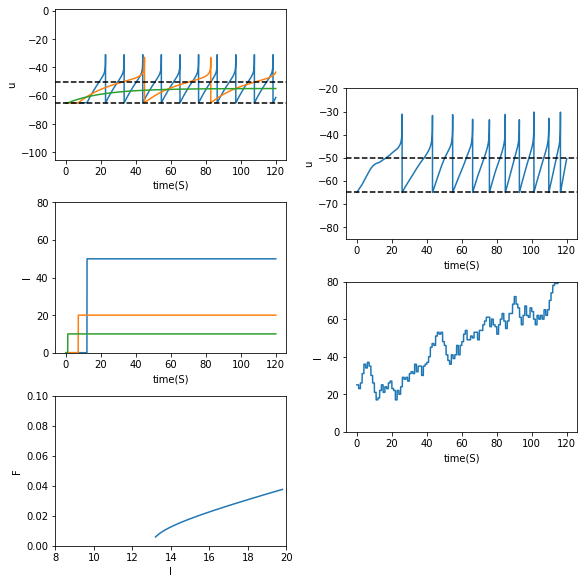

In [ ]:
elif_neuron1 = ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 2,u_rest = -65, R=1)
make_results(elif_neuron1, 120)

### Exp 2

hi


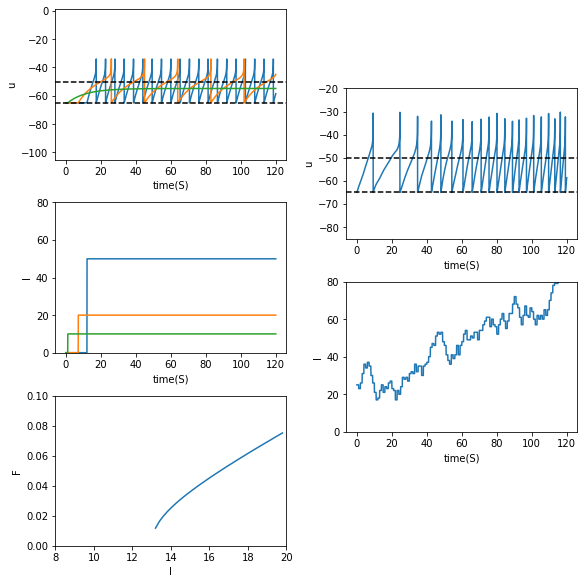

In [ ]:
elif_neuron2 = ELIF(tau = 10, firing_threshold = -50,reset_threshold = -30, sharpness= 2,u_rest = -65, R=1)
make_results(elif_neuron2, 120)

### Exp 3

hi


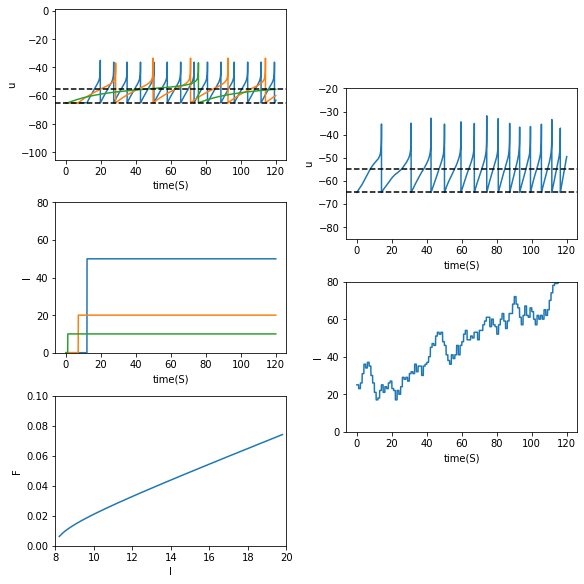

In [ ]:
elif_neuron3 = ELIF(tau = 20, firing_threshold = -55,reset_threshold = -30, sharpness= 2,u_rest = -65, R=1)
make_results(elif_neuron3, 120)

### Exp 4

hi


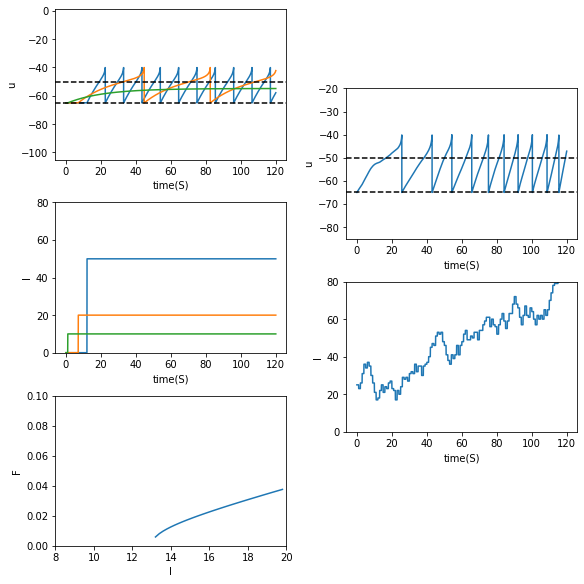

In [ ]:
elif_neuron4 = ELIF(tau = 20, firing_threshold = -50, reset_threshold = -40, sharpness= 2,u_rest = -65, R=1)
make_results(elif_neuron4, 120)

### Exp 5

hi


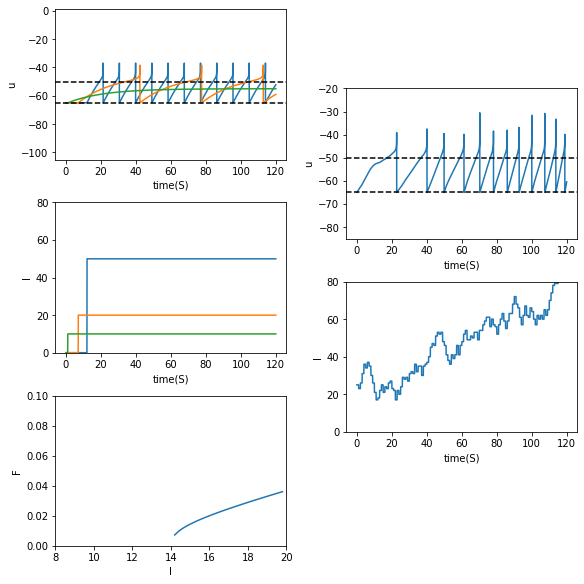

In [ ]:
elif_neuron5 = ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 1,u_rest = -65, R=1)
make_results(elif_neuron5, 120)

## Project 4

### Exp 1

hi


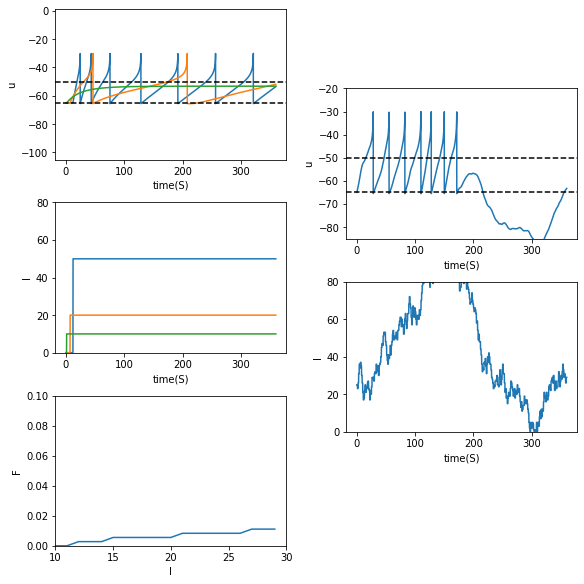

In [ ]:
a_elif_neuron1 = A_ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 4,u_rest = -65, R=1, a= 0, b=16, tau_w=144)
make_results(a_elif_neuron1, 360, 360, (10 , 30, 1))

### Exp 2

hi


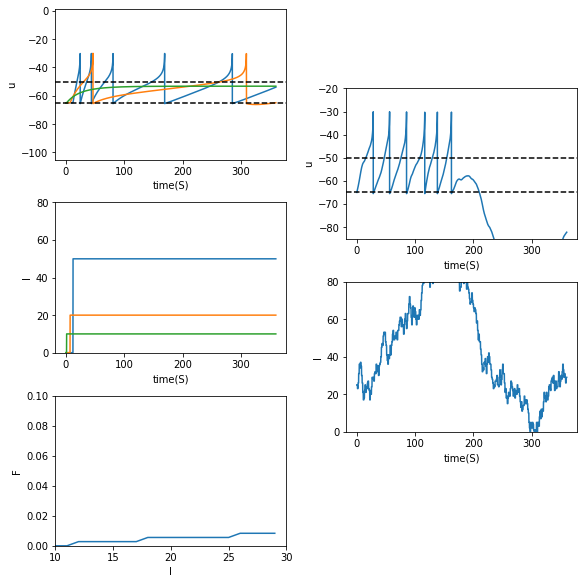

In [ ]:
a_elif_neuron2 = A_ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 4,u_rest = -65, R=1, a= 0, b=16, tau_w=288)
make_results(a_elif_neuron2, 360, 360, (10 , 30, 1))

### Exp 3

hi


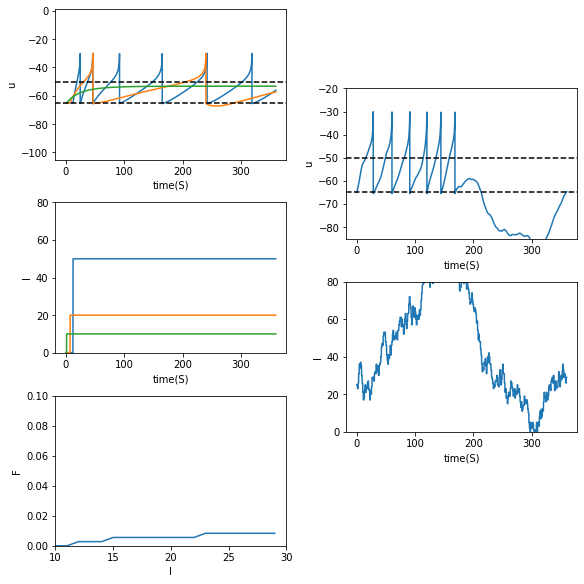

In [ ]:
a_elif_neuron3 = A_ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 4,u_rest = -65, R=1, a= 0, b=20, tau_w=144)
make_results(a_elif_neuron3, 360, 360, (10 , 30, 1))

### Exp 4

hi


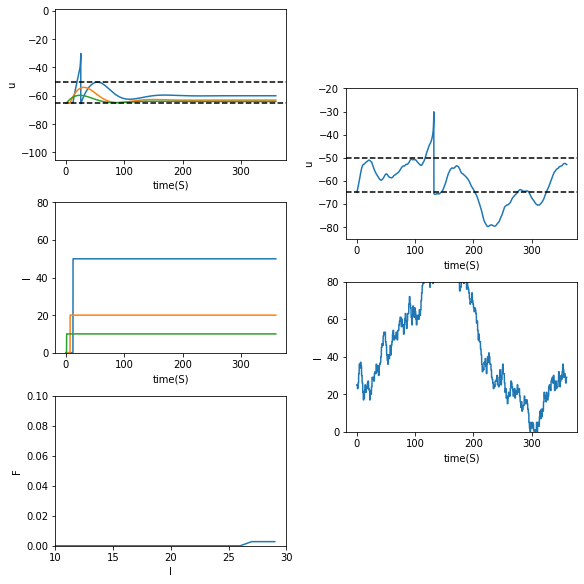

In [ ]:
a_elif_neuron4 = A_ELIF(tau = 20, firing_threshold = -50,reset_threshold = -30, sharpness= 4,u_rest = -65, R=1, a=9, b=16, tau_w=144)
make_results(a_elif_neuron4, 360, 360, (10 , 30, 1))

### Exp 5

hi


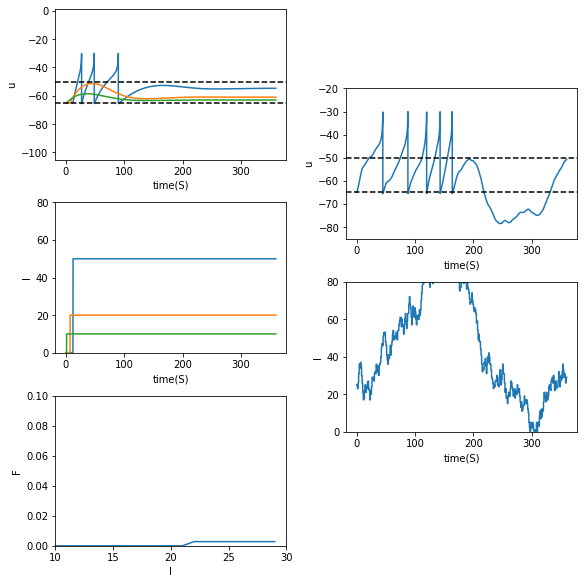

In [ ]:
a_elif_neuron5 = A_ELIF(tau = 23, firing_threshold = -50,reset_threshold = -30, sharpness= 4,u_rest = -65, R=1, a= 4, b=8, tau_w=144)
make_results(a_elif_neuron5, 360, 360, (10 , 30, 1))